In [1]:
from sklearn.manifold import TSNE
import tensorflow as tf
import numpy as np
import pywt
import matplotlib.pyplot as plt
from vae import VariationalAutoencoder, pre_process, filter_func, _parse_input, test_plot
from matplotlib.gridspec import GridSpec



def _parse_input(serialised_input):
    """ Parse serialised input into labelled dataset with NSynth features """
    parsed_output = tf.parse_single_example(serialised_input, nsynth_feature)
    return parsed_output


time_steps = 16000 * 4
wavelet = 'db1'
nsynth_feature = {
    'note': tf.FixedLenFeature([], tf.int64),
    'note_str': tf.FixedLenFeature([], tf.string),
    'instrument': tf.FixedLenFeature([], tf.int64),
    'instrument_str': tf.FixedLenFeature([], tf.string),
    'pitch': tf.FixedLenFeature([], tf.int64),
    'velocity': tf.FixedLenFeature([], tf.int64),
    'sample_rate': tf.FixedLenFeature([], tf.int64),
    'audio': tf.FixedLenFeature([time_steps], tf.float32),
    'qualities': tf.FixedLenFeature([10], tf.int64),
    'qualities_str': tf.VarLenFeature(tf.string),
    'instrument_family': tf.FixedLenFeature([], tf.int64),
    'instrument_family_str': tf.FixedLenFeature([], tf.string),
    'instrument_source': tf.FixedLenFeature([], tf.int64),
    'instrument_source_str': tf.FixedLenFeature([], tf.string),
}

sub_samp = 2
div = 8
time_steps = time_steps // sub_samp // div
batch_size = 50
n_samples = 289205

# Define number of nodes in each layer
vae_architecture = dict(
    n_hidden_recog_1=2000,
    n_hidden_recog_2=1000,
    n_hidden_gener_1=1000,
    n_hidden_gener_2=2000,
    n_input=time_steps,
    n_output=time_steps,
    n_z=64
)

vae = VariationalAutoencoder(vae_architecture, batch_size=batch_size, restore='DFT')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tmp/modelDFT.ckpt


In [2]:
nsynth_valid_2 = tf.data.TFRecordDataset("nsynth-valid.tfrecord")
nsynth_valid_1 = nsynth_valid_2.map(_parse_input)
nsynth_valid = nsynth_valid_1.filter(filter_func).shuffle(buffer_size=1000).repeat().batch(50)

iterator = nsynth_valid.make_one_shot_iterator().get_next()['audio']
valid = vae.sess.run(iterator)[:, :16000*4//div:sub_samp]

In [3]:
preproc = 'DFT'
valid_procc = pre_process(valid, preproc)
valid_recon = vae.reconstruct(valid_procc)
valid_recon = np.divide(valid_recon, np.amax(valid_recon, axis=1)[:, None]+1e-10)



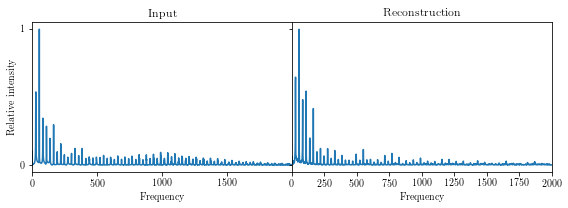

In [10]:
it=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig=plt.figure(figsize=(8,3))

gs=GridSpec(1,2) 

ax3=fig.add_subplot(gs[0,0])
ax4=fig.add_subplot(gs[0,1])


ax3.plot(np.arange(-2000, 2000), np.fft.fftshift(valid_procc[it]))
ax3.set_yticks([0, 1])
ax3.set_xlim([0, 2000])
ax3.set_xticks([0, 500, 1000, 1500])
ax3.set_ylabel('Relative intensity')
ax3.set_xlabel('Frequency')

ax4.plot(np.arange(-2000, 2000), np.fft.fftshift(valid_recon[it]))
ax4.set_xlim([0, 2000])
ax4.set_yticks([0, 1])
ax4.set_yticklabels([])
ax4.set_xlabel('Frequency')


plt.setp(ax3, title='Input')
plt.setp(ax4, title='Reconstruction')

plt.tight_layout()

gs.update(hspace=0.2, wspace=0)
fig.savefig('reconDFT.pdf')